In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
plt.rcParams['font.weight'] = 'bold'   # 设置字体加粗
plt.rcParams['axes.unicode_minus'] = False  # 上述字库没负号，因此负号不进行字体变换

一、求解衡量生态系统稳定性各指标权重的重要性

In [486]:
def ahp_weights(judgment_matrix):
    """
    计算AHP权重并返回权重向量。
    :param judgment_matrix: 判断矩阵（numpy数组）
    :return: 权重向量
    """
    # 归一化矩阵
    normalized_matrix = judgment_matrix / judgment_matrix.sum(axis=0)
    
    # 计算权重向量（每行的平均值）
    weights = normalized_matrix.mean(axis=1)
    
    return weights

def consistency_check(judgment_matrix, weights):
    """
    进行一致性检验，计算一致性比率（CR）。
    :param judgment_matrix: 判断矩阵（numpy数组）
    :param weights: 权重向量
    :return: 一致性比率（CR）
    """
    n = judgment_matrix.shape[0]
    
    # 计算加权向量
    weighted_vector = judgment_matrix @ weights
    
    # 计算最大特征值（λ_max）
    lambda_max = (weighted_vector / weights).mean()
    
    # 计算一致性指标（CI）
    CI = (lambda_max - n) / (n - 1)
    
    # 随机一致性指标（RI），查表得到
    RI = {1: 0, 2: 0, 3: 0.58, 4: 0.90, 5: 1.12, 6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45, 10: 1.49}
    
    # 计算一致性比率（CR）
    CR = CI / RI[n]
    
    return CR

def main():
    # 定义判断矩阵（3个因素：植物繁殖、生物多样性、长期可持续性）
    judgment_matrix = np.array([
        [1, 1/2, 1/2,2,2],      #害虫防治 vs 害虫防治 ; 害虫防治 vs 作物健康; 害虫防治 vs 植物繁殖、害虫防治vs 生物多样性、害虫防治 vs 长期可持续性
        [2, 1, 1,2,2],    #作物健康 vs 害虫防治 ; 作物健康 vs 作物健康; 作物健康 vs 植物繁殖、作物健康vs 生物多样性、作物健康 vs 长期可持续性
        [2, 1, 1,2,2],   #植物繁殖 vs 害虫防治 ; 植物繁殖 vs 作物健康; 植物繁殖 vs 植物繁殖、植物繁殖vs 生物多样性、植物繁殖 vs 长期可持续性
        [1/2,1/2,1,1,1/2],               #生物多样性 vs 害虫防治 ; 生物多样性 vs 作物健康; 生物多样性 vs 植物繁殖、生物多样性vs 生物多样性、生物多样性 vs 长期可持续性
        [1/2,1/2,1/2,1,1]               #长期可持续性 vs 害虫防治 ; 长期可持续性 vs 作物健康; 长期可持续性 vs 植物繁殖、长期可持续性vs 生物多样性、长期可持续性 vs 长期可持续性
    ])
    
    # 计算权重
    weights = ahp_weights(judgment_matrix)
    print("权重向量：", weights)
    
    # 进行一致性检验
    CR = consistency_check(judgment_matrix, weights)
    print("一致性比率（CR）：", CR)
    
    # 判断一致性是否可接受
    if CR < 0.1:
        print("一致性检验通过（CR < 0.1），判断矩阵合理。")
    else:
        print("一致性检验未通过（CR >= 0.1），请重新调整判断矩阵。")

if __name__ == "__main__":
    main()

权重向量： [0.1902381  0.27714286 0.27714286 0.13357143 0.12190476]
一致性比率（CR）： 0.044903159118668344
一致性检验通过（CR < 0.1），判断矩阵合理。


四、考虑有机农业的综合模型

（一）害虫防治：涉及鸟类和蝙蝠对害虫的防治,可以减少对杀虫剂的依赖

（二）作物健康：有机肥料的使用有利于改善土壤结构，进而增加作物的最大环境容量

（三）植物繁殖：自然授粉者比如蝙蝠会促进植物的繁殖率

（四）生物多样性：除草剂和杀虫剂的减少使用和边缘栖息地的回复将显著提高生物多样性

（五）长期可持续性：有机农业通过减少对外部投入的依赖性（依靠有机肥料施肥 +食物链进行害虫防治+减少除草剂和杀虫剂等化学物质的使用）

（六）成本效益：初期投入成本+经营成本+高额的经济效益

In [489]:
def simulated_annealing(goal_function, initial_solution, W, theta, max_iter=10000, initial_temp=100, cooling_rate=0.99):
    """
    Parameters:
    - goal_function: 目标函数，输入为决策变量、权重和超参数，输出为目标值。
    - initial_solution: 初始解（决策变量 X 的初始值）。
    - W: 权重列表。
    - theta: 超参数列表。
    - max_iter: 最大迭代次数。
    - initial_temp: 初始温度。
    - cooling_rate: 温度衰减率。

    Returns:
    - best_solution: 优化后的决策变量值。
    - best_score: 对应的目标函数值。
    """

    # 初始化
    current_solution = np.array(initial_solution)
    current_score = goal_function(current_solution, W, theta)
    best_solution = current_solution.copy()
    best_score = current_score
    temperature = initial_temp

    for iteration in range(max_iter):
        # 生成新解（通过小范围随机扰动当前解，并保持在 [0, 1]）
        new_solution = current_solution + np.random.uniform(-0.1, 0.1, size=len(current_solution))
        new_solution[0] = max(0, min(1, new_solution[0]))  # X[0] 范围 [0, 1]
        new_solution[1] = max(0, min(1, new_solution[1]))  # X[1] 范围 [0, 1]
        new_solution[2] = max(0, min(0.2,new_solution[2]))  # X[2] 范围 [0, 0.2]

        # 计算新解的目标函数值
        new_score = goal_function(new_solution, W, theta)

        # 判断是否接受新解
        if new_score > current_score or np.random.rand() < np.exp((new_score - current_score) / temperature):
            current_solution = new_solution
            current_score = new_score

        # 更新最优解
        if current_score > best_score:
            best_solution = current_solution.copy()
            best_score = current_score

        # 降低温度
        temperature *= cooling_rate

        if iteration % 100 == 0:
            print(f"Iteration {iteration}, Best Score: {best_score:.4f}, Temperature: {temperature:.2f}")

    return best_solution, best_score

def goal_function(X, W, theta):
    """
    包含惩罚项的目标函数
    """
    f1 = W[0] * (1 - X[1]) + W[1] * (X[0] - X[1]) + W[2] * (1 - X[1]) + W[3] * X[2] + W[4] * (X[0] - X[1])
    f2 = theta[0] * X[0] + theta[1] * (1-X[1]) + theta[2] * (1 - X[2]) - theta[3] * theta[4]*10*(1 - X[2])
    constraint_value=theta[4]*10*(1 - X[2])
    penalty = 0
    if constraint_value >= 1:  # 如果违反约束条件，增加惩罚
        penalty = float("inf")
    
    return W[5] * f1/0.1 - W[6] * f2/1 -penalty

In [499]:
eta1=0.6
eta2=1-eta1
initial_solution = [0.5, 0.5, 0.2]  # 初始解
W = [0.19, 0.28, 0.28, 0.13, 0.12, eta1, eta2]  # 权重
theta = [4, 3, 6, 8, 0.1]  # 超参数
# 调用模拟退火算法
best_solution, best_score = simulated_annealing(goal_function, initial_solution, W, theta)
print(best_solution)
print(best_score)

Iteration 0, Best Score: 0.8060, Temperature: 99.00
Iteration 100, Best Score: 3.0163, Temperature: 36.24
Iteration 200, Best Score: 3.0163, Temperature: 13.26
Iteration 300, Best Score: 3.0163, Temperature: 4.86
Iteration 400, Best Score: 3.1348, Temperature: 1.78
Iteration 500, Best Score: 3.2181, Temperature: 0.65
Iteration 600, Best Score: 3.2181, Temperature: 0.24
Iteration 700, Best Score: 3.2187, Temperature: 0.09
Iteration 800, Best Score: 3.2197, Temperature: 0.03
Iteration 900, Best Score: 3.2200, Temperature: 0.01
Iteration 1000, Best Score: 3.2200, Temperature: 0.00
Iteration 1100, Best Score: 3.2200, Temperature: 0.00
Iteration 1200, Best Score: 3.2200, Temperature: 0.00
Iteration 1300, Best Score: 3.2200, Temperature: 0.00
Iteration 1400, Best Score: 3.2200, Temperature: 0.00
Iteration 1500, Best Score: 3.2200, Temperature: 0.00
Iteration 1600, Best Score: 3.2200, Temperature: 0.00
Iteration 1700, Best Score: 3.2200, Temperature: 0.00
Iteration 1800, Best Score: 3.2200, T

Iteration 0, Best Score: -1.8049, Temperature: 99.00
Iteration 100, Best Score: 0.7730, Temperature: 36.24
Iteration 200, Best Score: 0.7730, Temperature: 13.26
Iteration 300, Best Score: 1.9549, Temperature: 4.86
Iteration 400, Best Score: 1.9549, Temperature: 1.78
Iteration 500, Best Score: 1.9549, Temperature: 0.65
Iteration 600, Best Score: 1.9549, Temperature: 0.24
Iteration 700, Best Score: 1.9942, Temperature: 0.09
Iteration 800, Best Score: 1.9942, Temperature: 0.03
Iteration 900, Best Score: 1.9942, Temperature: 0.01
Iteration 1000, Best Score: 1.9942, Temperature: 0.00
Iteration 1100, Best Score: 1.9942, Temperature: 0.00
Iteration 1200, Best Score: 1.9942, Temperature: 0.00
Iteration 1300, Best Score: 1.9942, Temperature: 0.00
Iteration 1400, Best Score: 1.9942, Temperature: 0.00
Iteration 1500, Best Score: 1.9942, Temperature: 0.00
Iteration 1600, Best Score: 1.9942, Temperature: 0.00
Iteration 1700, Best Score: 1.9957, Temperature: 0.00
Iteration 1800, Best Score: 1.9957, 

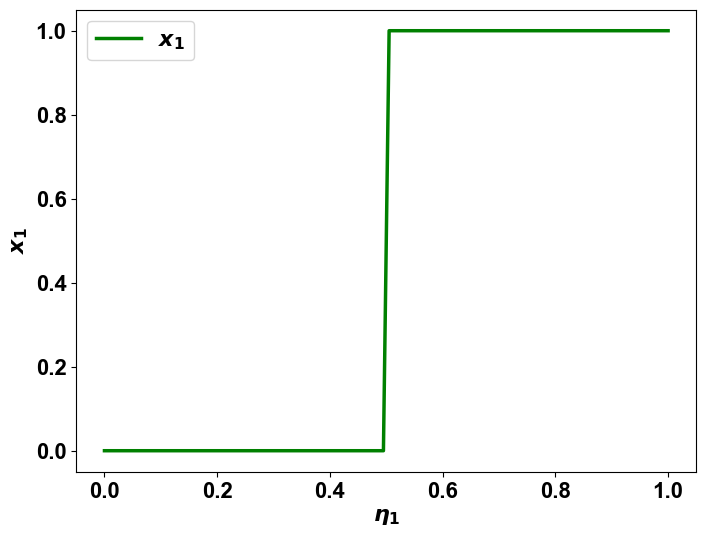

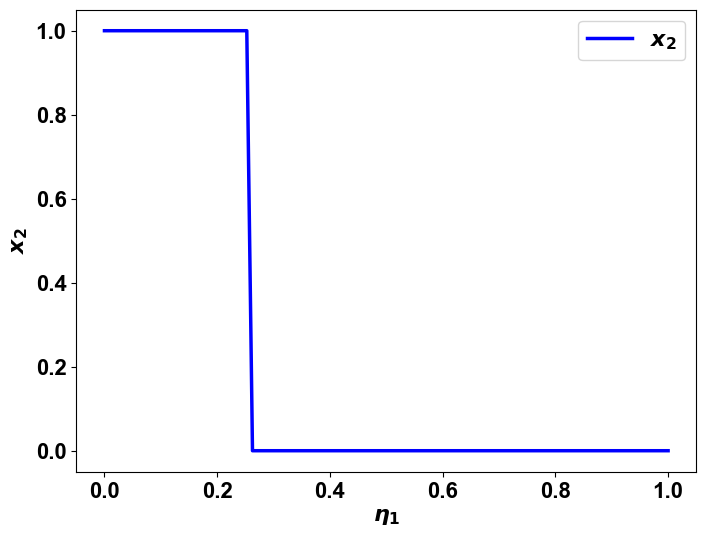

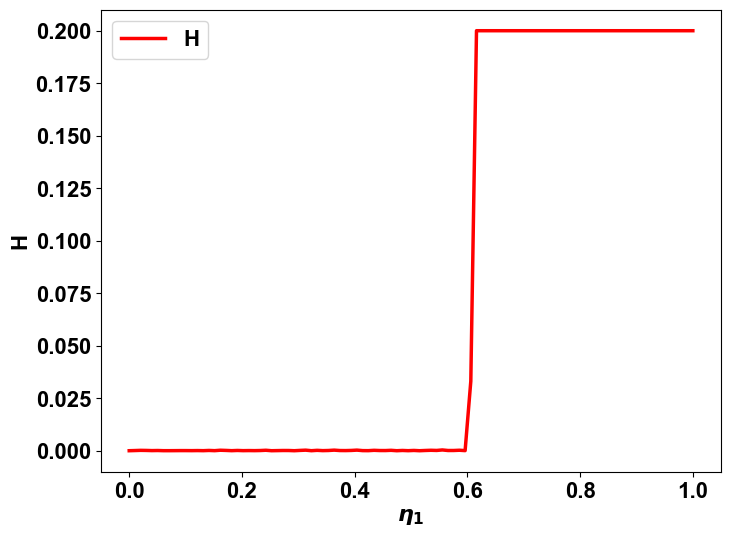

In [496]:
result1=[]
result2=[]
eta1=np.linspace(0, 1, 100)
for i in eta1:
    eta2=1-i
    initial_solution = [0.5, 0.5, 0.2]  # 初始解
    W = [0.19, 0.28, 0.28, 0.13, 0.12, i, eta2]  # 权重
    theta = [4, 3, 6, 8, 0.1]  # 超参数
    # 调用模拟退火算法
    best_solution, best_score = simulated_annealing(goal_function, initial_solution, W, theta)
    result1.append(best_solution)
    result2.append(best_score)
result1=np.array(result1)
result2=np.array(result2)
plt.figure(figsize=(8,6))
plt.plot(eta1,result1[:,0],c="g",linewidth=2.5,label=r"$x_{1}$")
plt.xlabel(r"$\eta_{1}$")
plt.ylabel(r"$x_{1}$")
plt.legend()
plt.figure(figsize=(8,6))
plt.plot(eta1,result1[:,1],c="b",linewidth=2.5,label=r"$x_{2}$")
plt.xlabel(r"$\eta_{1}$")
plt.ylabel(r"$x_{2}$")
plt.legend()
plt.figure(figsize=(8,6))
plt.plot(eta1,result1[:,2],c="r",linewidth=2.5,label="H")
plt.xlabel(r"$\eta_{1}$")
plt.ylabel("H",weight="bold")
plt.legend()

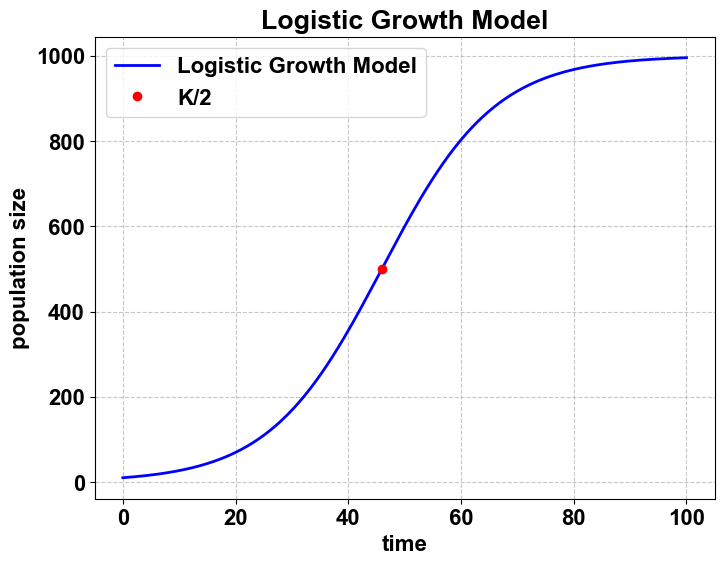

In [11]:

# 定义Logistic增长模型参数
r = 0.1  # 增长率
K = 1000  # 环境承载能力
N0 = 10   # 初始数量
time = 100  # 时间范围（单位自定）

# 创建时间序列
t = np.linspace(0, time, 200)

# 计算Logistic增长曲线
N = K / (1 + (K/N0 - 1)*np.exp(-r*t))

# 创建画布
plt.figure(figsize=(8, 6))

# 绘制增长曲线
plt.plot(t, N, 'b-', label='Logistic Growth Model', linewidth=2)

# 添加特征点（拐点）
inflection_point = np.log((K/N0 - 1))/r
N_inflection = K/2
plt.plot(inflection_point, N_inflection, 'ro', label='K/2')

# 设置图表属性
plt.title("Logistic Growth Model",weight="bold")
plt.xlabel("time",weight="bold")
plt.ylabel("population size",weight="bold")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# 显示图像
plt.show()